# Retail Analytics

This notebook scenario is [Microsoft Surface](https://www.microsoft.com/en-us/surface) sales forecasting, with artificially created data. **A distributor wants to predict how many units are necessary in the local warehouse to supply the stores in the area.**

&nbsp;

We will use Quantitative Models to forecast future data as a function of past data. They are appropriate to use when past numerical data is available and when it is reasonable to assume that some of the patterns in the data are expected to continue into the future. These methods are usually applied to short or intermediate range decisions. For more information, click [here](https://en.wikipedia.org/wiki/Forecasting).

&nbsp;

<img src="https://cosmosnotebooksdata.blob.core.windows.net/notebookdata/store.PNG" alt="Surface Device" width="75%"/>

&nbsp;



### Step 1 - Setup

Create a database and a container for our data. Let's start with a 30K RU/s container, to load the data quickly. [Cosmos DB SDK for Python](https://github.com/Azure/azure-sdk-for-python/tree/master/sdk/cosmos) is pre-installed in Cosmic Notebooks like this one.

In [21]:
import azure.cosmos
from azure.cosmos.partition_key import PartitionKey

initialThroughput = 30000


database = cosmos_client.create_database_if_not_exists('CosmosAnalyticsDemoDb')
print('Database CosmosAnalyticsDemoDb created')

container = database.create_container_if_not_exists(id='RetailData', partition_key=PartitionKey(path='/storeId'),offer_throughput=initialThroughput)
print('Container RetailData created')

Database CosmosAnalyticsDemoDb created
Container RetailData created


## Step 2 - Loading the Data
In this step we will:

&nbsp


+ Update the throughput of the container to allow for a quicker upload. 
+ Use the ``%%upload`` magic function to insert items into the container, what will take ~1 minute.
+ Lower the throughput after the upload. For more information, check the **3. RequestUnits** notebook.


&nbsp

Data Dictionary:

&nbsp

+ id = unique sequential identifier
+ date = first day of the week
+ storeId = id of the store.
+ productId = id of the product
+ productCode = product description
+ quantity = units sold in the week
+ advertising = Did the store do advertising in that week?
+ price = price of the product in the store in the week
+ college = percentage of the store's region population that has a college degree. Repeated per store.
+ income = median income of the store's region population. Repeated per store.
+ highIncome150 = percentage of the store's region households that worth more than $150,000. Repeated per store.
+ largeHH =  percentage of the store's region households with 5+ persons. Repeated per store.
+ ratioNearest5Stores = ratio of sales of this store to the average of the nearest five stores

&nbsp

Our dataset has 28947 JSON documents like this one:

```json
    {
        "id": "1",
        "weekStarting": "6/14/2019",
        "storeId": "2",
        "productId": "1",
        "productCode": "surface.go",
        "quantity": "10",
        "advertising": "1",
        "price": "397.50",
        "age60": "0.232864734",
        "college": "0.248934934",
        "income": "10.55320518",
        "highIncome150": "0.463887065",
        "largeHH": "0.103953406",
        "ratioNearest5Stores": "0.376926613"
    },
```


In [19]:
%%upload --databaseName CosmosAnalyticsDemoDb --containerName RetailData  --url https://cosmosnotebooksdata.blob.core.windows.net/notebookdata/SurfaceSales.json

Documents successfully uploaded to RetailData 
Total number of documents imported: 
  Success: 28947 
  Failure: 0 
Total time taken : 00:00:13 hours 
Total RUs consumed : 358363.86000010406

In [22]:
newThroughput = 400
lowered_throughput = container.replace_throughput(newThroughput).offer_throughput
print("Container RetailData's throughput lowered from {} RU/s to {} RU/s".format(initialThroughput, newThroughput))

Container RetailData's throughput lowered from 30000 RU/s to 400 RU/s


## Step 3 - Loading the data into a DataFrame

&nbsp

We'll use the ```%%sql``` magic command to query the data and load the results into a Pandas datafram. The syntax is:   

&nbsp

```sql
%%sql --database {database_id} --container {container_id} --output outputDataframeVar
{Query text}
```

In [23]:
%%sql --database CosmosAnalyticsDemoDb  --container RetailData --output df_retail
SELECT c.weekStarting, c.quantity, c.price, c.productCode, c.storeId, c.id, c.income, c.totalSales, c.advertising  FROM c 

▶ View Query Metrics 
 
 
 
 totalExecutionTimeInMs : 460.50000000000006 queryCompileTimeInMs : 3.82 queryLogicalPlanBuildTimeInMs : 1.1000000000000005 queryPhysicalPlanBuildTimeInMs : 0.15 queryOptimizationTimeInMs : 0 VMExecutionTimeInMs : 445.66999999999996 indexLookupTimeInMs : 0 documentLoadTimeInMs : 178.69999999999996 systemFunctionExecuteTimeInMs : 0 userFunctionExecuteTimeInMs : 0 retrievedDocumentCount : 28947 retrievedDocumentSize : 20271001 outputDocumentCount : 28947 outputDocumentSize : 5092226 writeOutputTimeInMs : 113.74 averageIndexUtilizationRation : 1

## Step 4 - Importing the libraries and checking the DataFrame size

In [24]:
import pandas as pd 
import numpy as np 
import matplotlib.pyplot as plt 
import warnings 

# Turning off unnecessary warnings
warnings.filterwarnings("ignore")

len(df_retail)

28947

## Step 5 - Checking the Data

Let's check the data and get some insights. We'll se the built-in [nteract data explorer](https://blog.nteract.io/designing-the-nteract-data-explorer-f4476d53f897) to allow data visualizations. After the following code lines, all cells will be enabled with nteract data explorer, with multiple visualization options on the right side of the result sets. For more information, check the **2.Visualization** notebook.

&nbsp

A suggested visualization is to compare quantity x price in a **Line Chart**.

In [25]:
# Turning on the visualization options
pd.options.display.html.table_schema = True
pd.options.display.max_rows = None

# Example: let's see the data about productId 1
df_retail[(df_retail.productCode == 'surface.laptop3') & (df_retail.storeId == 137)]

,weekStarting,quantity,price,productCode,storeId,id,income,advertising
28044,06-27-2019,150,313,surface.laptop3,137,3a8711c8-eb49-46de-8b42-64913677567a,10.9665,1
28045,06-20-2019,926,199,surface.laptop3,137,e32cc4d8-ff5b-4a73-90cb-888c4d924be8,10.9665,1
28046,06-13-2019,1001,225,surface.laptop3,137,365742ae-d98e-40f3-b995-08325a73b199,10.9665,0
28047,06-06-2019,1450,249,surface.laptop3,137,754964a6-fb11-47ca-8a5e-2869ecc8be37,10.9665,1
28048,05-30-2019,231,319,surface.laptop3,137,f8c5100f-124c-45c6-976e-b241df46660d,10.9665,0
28049,05-23-2019,199,319,surface.laptop3,137,34e91ed2-3391-48b2-8cc0-bf94e1aca28f,10.9665,0
28050,05-16-2019,279,319,surface.laptop3,137,18a1382e-603e-4545-9efa-b56eee755b31,10.9665,0
28051,05-09-2019,304,319,surface.laptop3,137,d34ffb96-d0d9-4716-9271-610235467770,10.9665,0
28052,05-02-2019,803,239,surface.laptop3,137,77b51df5-b3bb-43b2-9285-179e41b8f9c7,10.9665,1
28053,04-25-2019,257,274,surface.laptop3,137,aa5eb20a-b9d2-4235-8591-d884c363f1d3,10.9665,0


## Step 6 - Data Preparation

Let's prepare a dataframe for our initial methods, based on average. Since we have different time series and quatities per store, we will abstract that level and calculate the average of the quantity per date, what is useful for the logistics distribution of products in the area.

&nbsp

Since we will use average based methods for forecasting, it is important to analyze the products separately. Since this is a sample notebook, we will only analyzer product with id = 1. Other standard data preparation operations like missing data, outliers, and duplicates removal are also aplied. 

&nbsp

At the end of this step, we will separete train (90%) and test (10%) data. For machine learning methods, this proportion should be different and we also need to create a validation dataset. For more information, click [here](https://en.wikipedia.org/wiki/Training,_validation,_and_test_sets).


In [26]:
# One product and empty data removal
df=df_retail[(df_retail.productCode == 'surface.laptop3')]
df=df.dropna()


# to date
df['date']=pd.to_datetime(df.weekStarting)

# Mean to remove outliers quikly. For production scenarios, use another method.
df2=df[[ 'date','quantity']] 
df2=df2.groupby(['date']).mean()
df=df2

#Creating train and test set 
rows = len(df)
rows=int((len(df)/10)*9)
train=df[0:rows] 
test=df[rows:]

# Checking the size of the data
print(len(train),len(test))

108 13


## Step 7 - Libraries

In this step we will install 2 libraries:

&nbsp

+ [Scikit-learn](https://scikit-learn.org/stable/index.html): Open source machine learning library that supports supervised and unsupervised learning. It also provides various tools for model fitting, data preprocessing, model selection and evaluation, and many other utilities. We will use its' evaluation features to calculate the [Root Mean Square Error](https://en.wikipedia.org/wiki/Root-mean-square_deviation).

+ [Statsmodels](statsmodels.org): Python module that provides classes and functions for the estimation of many different statistical models, as well as for conducting statistical tests, and statistical data exploration. An extensive list of result statistics are available for each estimator. The results are tested against existing statistical packages to ensure that they are correct. 

### Root Mean Square Error (RMSE)

RMSE is a frequently used measure of the differences between values (sample or population values) predicted by a model or an estimator and the values observed. It represents the square root of the second sample moment of the differences between predicted values and observed values or the quadratic mean of these differences. These deviations are called residuals when the calculations are performed over the data sample that was used for estimation and are called errors (or prediction errors) when computed out-of-sample. 

&nbsp

It is the square root of the average of squared errors. The effect of each error on RMSE is proportional to the size of the squared error; thus larger errors have a disproportionately large effect on RMSE. Consequently, RMSE is sensitive to outliers, that's why we're mitigating them, by store and by day.

&nbsp

> **Did you know?** RMSE are also called RMSD: Root-Mean-Square Deviation.

&nbsp

> **Did you know?** The lower the RMSE, the better your algorithm.



In [27]:
pip install sklearn

Defaulting to user installation because normal site-packages is not writeable
You should consider upgrading via the '/usr/bin/python3 -m pip install --upgrade pip' command.
Note: you may need to restart the kernel to use updated packages.


In [28]:
pip install statsmodels

Defaulting to user installation because normal site-packages is not writeable
You should consider upgrading via the '/usr/bin/python3 -m pip install --upgrade pip' command.
Note: you may need to restart the kernel to use updated packages.


## Step 7 - Plotting Train and Test Data

&nbsp

Now let's check the data we will use in our algorithms. It will help us to understand what we will process and the results we got from the data.

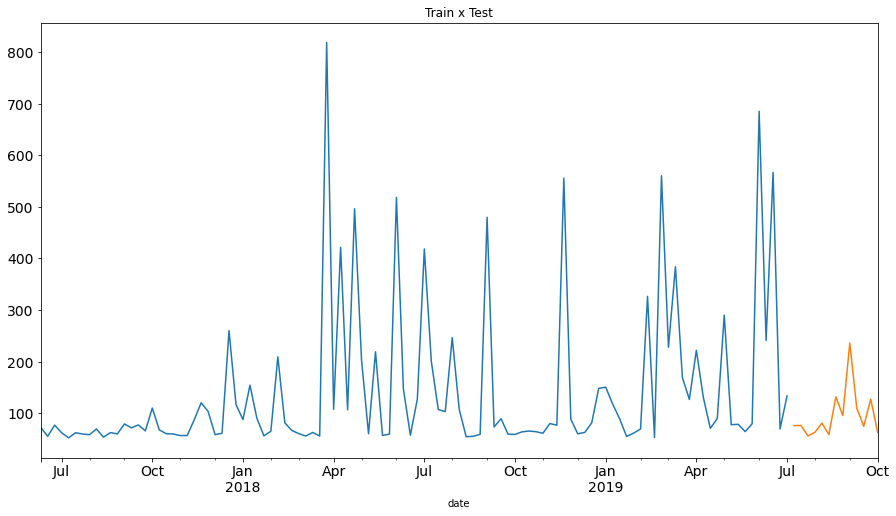

In [29]:
#Plotting data
train.quantity.plot(figsize=(15,8), title= 'Train x Test', fontsize=14)
test.quantity.plot(figsize=(15,8), title= 'Train x Test', fontsize=14)
plt.show()

### Creating a DataFrame for the results
Please notice that RMSE will return the error in units. So, let's create a DataFrame to save the results and compare them at the end of the notebook. Let's also create a baseline value with the total of units in the test period.

In [30]:
#Creating an empty dataframe for the results
results = pd.DataFrame(columns = ['Method','RMSE','Baseline','Diff%'])

#Let's calculate the Baseline
baseline=float(test.sum())
print('The Baseline is: ',baseline)



The Baseline is:  1249.457242546483


## Step 8 - Naive Forecast

&nbsp

This technique assumes that the next expected point is equal to the last observed point is called Naive Method. It's not suited for datasets with high variability, but may be a good option since we removed the outliers and applied a function to create mean values.

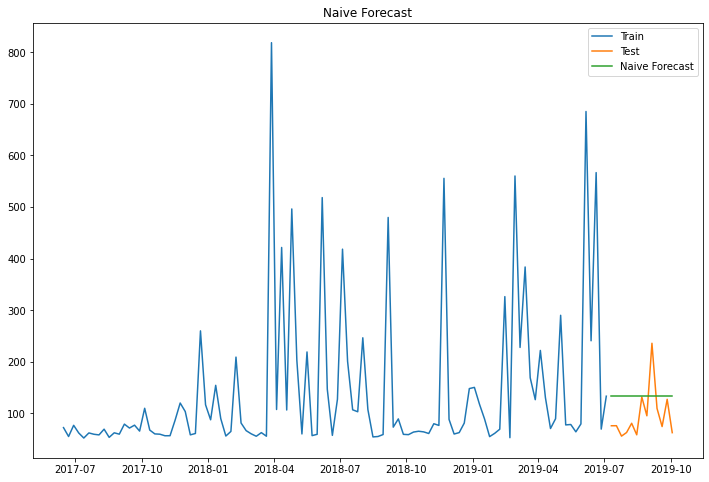

In [31]:
dd= np.asarray(train.quantity)
y_hat = test.copy()
y_hat['naive'] = dd[len(dd)-1]
plt.figure(figsize=(12,8))
plt.plot(train.index, train['quantity'], label='Train')
plt.plot(test.index,test['quantity'], label='Test')
plt.plot(y_hat.index,y_hat['naive'], label='Naive Forecast')
plt.legend(loc='best')
plt.title("Naive Forecast")
plt.show()

### Checking RMSE: Root Mean Square Error

In [32]:
from sklearn.metrics import mean_squared_error
from math import sqrt
rmse = sqrt(mean_squared_error(test.quantity, y_hat.naive))
newrow={'Method': 'Naive Forecast', 'RMSE': rmse, 'Baseline':baseline, 'Diff%':(rmse/baseline)*100}
results=results.append (newrow, ignore_index=True)
#print(rmse)
print(results)

           Method       RMSE     Baseline     Diff%
0  Naive Forecast  60.051558  1249.457243  4.806212


## Step 9 - Average Forecast

&nbsp

This technique forecasts the expected value equal to the average of all previously observed points is called Simple Average technique. This method works best when the average at each time period remains constant. 

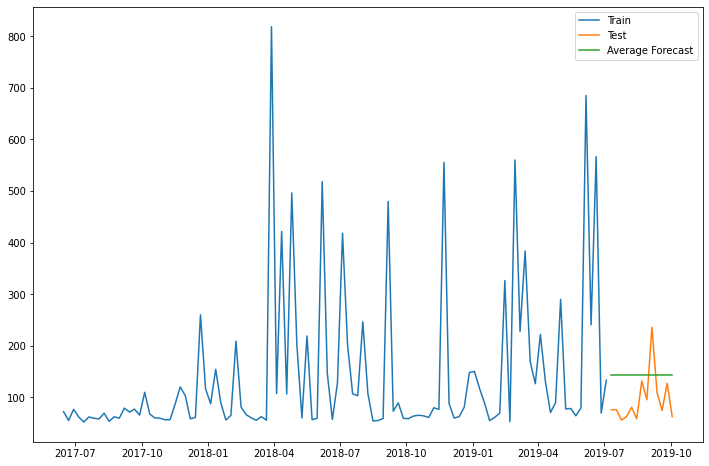

In [33]:
y_hat_avg = test.copy()
y_hat_avg['avg_forecast'] = train['quantity'].mean()
plt.figure(figsize=(12,8))
plt.plot(train['quantity'], label='Train')
plt.plot(test['quantity'], label='Test')
plt.plot(y_hat_avg['avg_forecast'], label='Average Forecast')
plt.legend(loc='best')
plt.show()

### Checking RMSE: Root Mean Square Error

In [34]:
rmse = sqrt(mean_squared_error(test.quantity, y_hat_avg.avg_forecast))
newrow={'Method': 'Average Forecast', 'RMSE': rmse, 'Baseline':baseline, 'Diff%':(rmse/baseline)*100}
results=results.append (newrow, ignore_index=True)
#print(rmse)
print(results)

             Method       RMSE     Baseline     Diff%
0    Naive Forecast  60.051558  1249.457243  4.806212
1  Average Forecast  66.246420  1249.457243  5.302016


## Step 10 - Simple Exponential Smoothing (SME)

&nbsp

Forecasts are calculated using weighted averages where the weights decrease exponentially as observations come from further in the past, the smallest weights are associated with the oldest observations.

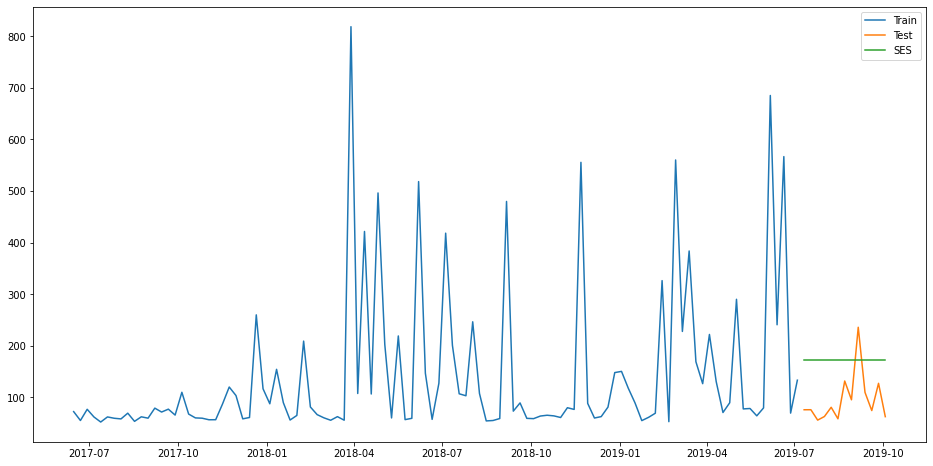

In [35]:
from statsmodels.tsa.api import ExponentialSmoothing, SimpleExpSmoothing, Holt
y_hat_avg = test.copy()
fit2 = SimpleExpSmoothing(np.asarray(train['quantity'])).fit(smoothing_level=0.6,optimized=False)
y_hat_avg['SES'] = fit2.forecast(len(test))
plt.figure(figsize=(16,8))
plt.plot(train['quantity'], label='Train')
plt.plot(test['quantity'], label='Test')
plt.plot(y_hat_avg['SES'], label='SES')
plt.legend(loc='best')
plt.show()

### Checking RMSE: Root Mean Square Error

In [36]:
rmse = sqrt(mean_squared_error(test.quantity, y_hat_avg.SES))
newrow={'Method': 'SME', 'RMSE': rmse, 'Baseline':baseline, 'Diff%':(rmse/baseline)*100}
results=results.append (newrow, ignore_index=True)
#print(rmse)
print(results)

             Method       RMSE     Baseline     Diff%
0    Naive Forecast  60.051558  1249.457243  4.806212
1  Average Forecast  66.246420  1249.457243  5.302016
2               SME  89.110980  1249.457243  7.131975


## Step 11- Moving Average

&nbsp

Using the prices of the initial period would highly affect the forecast for the next period. Therefore as an improvement over simple average, we will take the average of the prices for last few time periods only. Obviously the thinking here is that only the recent values matter.

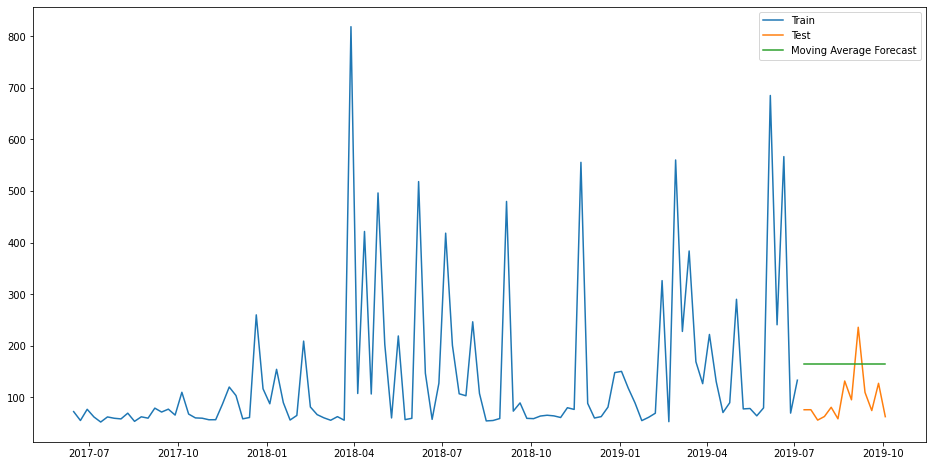

In [37]:
y_hat_avg = test.copy()
y_hat_avg['moving_avg_forecast'] = train['quantity'].rolling(60).mean().iloc[-1]
plt.figure(figsize=(16,8))
plt.plot(train['quantity'], label='Train')
plt.plot(test['quantity'], label='Test')
plt.plot(y_hat_avg['moving_avg_forecast'], label='Moving Average Forecast')
plt.legend(loc='best')
plt.show()

### Checking RMSE: Root Mean Square Error

In [38]:
rmse = sqrt(mean_squared_error(test.quantity, y_hat_avg.moving_avg_forecast))
newrow={'Method': 'Moving Average', 'RMSE': rmse, 'Baseline':baseline, 'Diff%':(rmse/baseline)*100}
results=results.append (newrow, ignore_index=True)
#print(rmse)
print(results)

             Method       RMSE     Baseline     Diff%
0    Naive Forecast  60.051558  1249.457243  4.806212
1  Average Forecast  66.246420  1249.457243  5.302016
2               SME  89.110980  1249.457243  7.131975
3    Moving Average  83.420270  1249.457243  6.676521


## Step 12 - Holt’s Linear Trend

&nbsp

Each Time series dataset can be decomposed into it’s componenets which are Trend, Seasonality and Residual. Any dataset that follows a trend can use Holt’s linear trend method for forecasting.

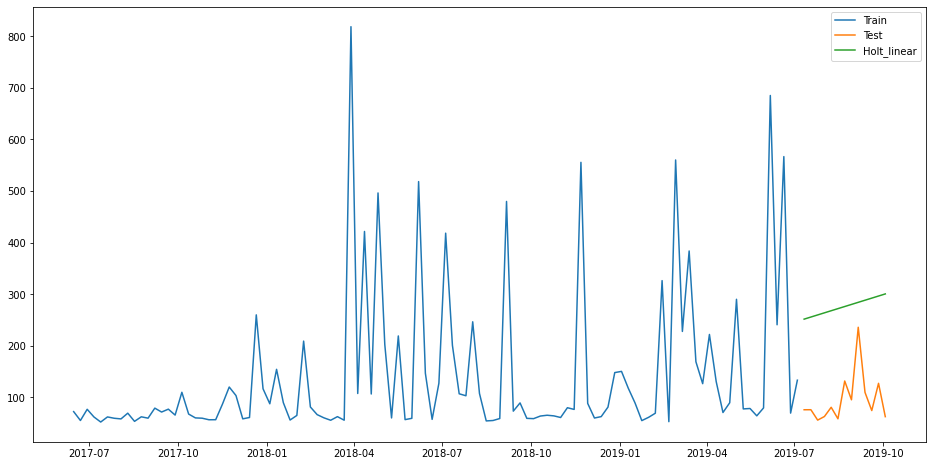

In [39]:
y_hat_avg = test.copy()

fit1 = Holt(np.asarray(train['quantity'])).fit(smoothing_level = 0.3,smoothing_slope = 0.1)
y_hat_avg['Holt_linear'] = fit1.forecast(len(test))

plt.figure(figsize=(16,8))
plt.plot(train['quantity'], label='Train')
plt.plot(test['quantity'], label='Test')
plt.plot(y_hat_avg['Holt_linear'], label='Holt_linear')
plt.legend(loc='best')
plt.show()

### Checking RMSE: Root Mean Square Error

In [40]:
rmse = sqrt(mean_squared_error(test.quantity, y_hat_avg.Holt_linear))
newrow={'Method': 'Holts Linear Trend', 'RMSE': rmse, 'Baseline':baseline, 'Diff%':(rmse/baseline)*100}
results=results.append (newrow, ignore_index=True)
#print(rmse)
print(results)

               Method        RMSE     Baseline      Diff%
0      Naive Forecast   60.051558  1249.457243   4.806212
1    Average Forecast   66.246420  1249.457243   5.302016
2                 SME   89.110980  1249.457243   7.131975
3      Moving Average   83.420270  1249.457243   6.676521
4  Holts Linear Trend  185.535994  1249.457243  14.849327


## Step 13 - Holt Linear

&nbsp

Using Holt’s winter method will be the best option among the rest of the models beacuse of the seasonality factor. The Holt-Winters seasonal method comprises the forecast equation and three smoothing equations — one for the level ℓt, one for trend bt and one for the seasonal component denoted by st, with smoothing parameters α, β and γ.

/home/cosmosuser/.local/lib/python3.6/site-packages/statsmodels/tsa/holtwinters.py:744: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  ConvergenceWarning)


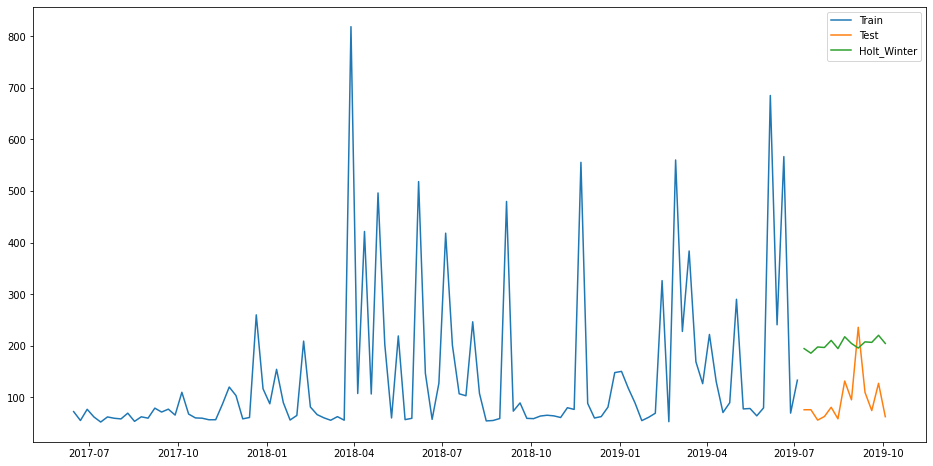

In [41]:
y_hat_avg = test.copy()
fit1 = ExponentialSmoothing(np.asarray(train['quantity']) ,seasonal_periods=7 ,trend='add', seasonal='add',).fit()
y_hat_avg['Holt_Winter'] = fit1.forecast(len(test))
plt.figure(figsize=(16,8))
plt.plot( train['quantity'], label='Train')
plt.plot(test['quantity'], label='Test')
plt.plot(y_hat_avg['Holt_Winter'], label='Holt_Winter')
plt.legend(loc='best')
plt.show()

### Checking RMSE: Root Mean Square Error + SORTING THE FINAL RESULTS

In [42]:
rmse = sqrt(mean_squared_error(test.quantity, y_hat_avg.Holt_Winter))
newrow={'Method': 'Holts Linear', 'RMSE': rmse, 'Baseline':baseline, 'Diff%':(rmse/baseline)*100}
results=results.append (newrow, ignore_index=True)
#print(rmse)

#Sorting and printing
results=results.sort_values(by='RMSE')
print(results)

               Method        RMSE     Baseline      Diff%
0      Naive Forecast   60.051558  1249.457243   4.806212
1    Average Forecast   66.246420  1249.457243   5.302016
3      Moving Average   83.420270  1249.457243   6.676521
2                 SME   89.110980  1249.457243   7.131975
5        Holts Linear  116.379515  1249.457243   9.314406
4  Holts Linear Trend  185.535994  1249.457243  14.849327


## Conclusion

Check the results in the table above, they are sorted by ther RMSE, showing you the best method for [Surface Go](https://www.microsoft.com/en-us/surface), what is the product with id 1. Now you can run everything for another product, just changing the filter in the data preparation cell. Or you may want to create sophisticated models to use the other interesting information of the dataset.